## Libraries

In [1]:
import pandas as pd
import numpy as np
from crepes import ConformalClassifier, ConformalPredictiveSystem
from crepes.extras import hinge, margin, binning, DifficultyEstimator

## Data

### Calibration 

In [24]:
# xxx = df_cal[df_cal['gt_obj_id']==df_cal['pred_obj_id']]
# unique_counts = xxx['gt_obj_id'].value_counts()
# print(unique_counts)

In [44]:
# Load the dataset
data_dir = "challenge_dataset.xlsx"  # directory
df_cal = pd.read_excel(data_dir, sheet_name='cal_challenge')  # cal dataset with conf=0.25

# Filter for True Positive Predictions Only
df_cal_tp = df_cal[df_cal['gt_obj_id'] == df_cal['pred_obj_id']]

# Define the sample size
sample_size = 80

# Set a seed for the random number generator
seed = 100

# Sample without replacement to ensure a row isn't sampled more than once
df_sampled = df_cal_tp.groupby('pred_obj_id').apply(lambda x: x.sample(min(len(x), sample_size), replace=False, random_state=seed)).reset_index(drop=True)

df_test=pd.read_excel(data_dir,sheet_name='test_challenge') #test dataset with conf=0.25
df_test_filtered = df_test[df_test['pred_obj_id'].notna()]
df_calibration=df_sampled
df_testing=df_test_filtered

In [19]:
unique_counts = df_calibration['gt_obj_id'].value_counts()
# print(unique_counts)

In [45]:
# Assuming df_cal_tp is your dataframe and there are 4 classes (0 to 3)
num_classes = 11  # Update this based on the actual number of classes
class_columns = [f'class_{i}_conf_score' for i in range(num_classes)]

# Always include 'gt_obj_id' and 'pred_obj_id'
base_columns = ['gt_obj_id', 'pred_obj_id','objectness_score']

# Combine the base columns with the dynamically generated class columns
selected_columns = base_columns + class_columns

# Now, assuming you have renamed the original columns to match this new naming convention,
# you can select these columns from your dataframe
df_subset = df_cal_tp[selected_columns]

C:\Users\M\AppData\Local\Temp\ipykernel_12672\2340280042.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1), include_lowest=True)
C:\Users\M\AppData\Local\Temp\ipykernel_12672\2340280042.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1), include_lowest=True)
C:\Users\M\AppData\Local\Temp\ipykernel_12672\2340280042

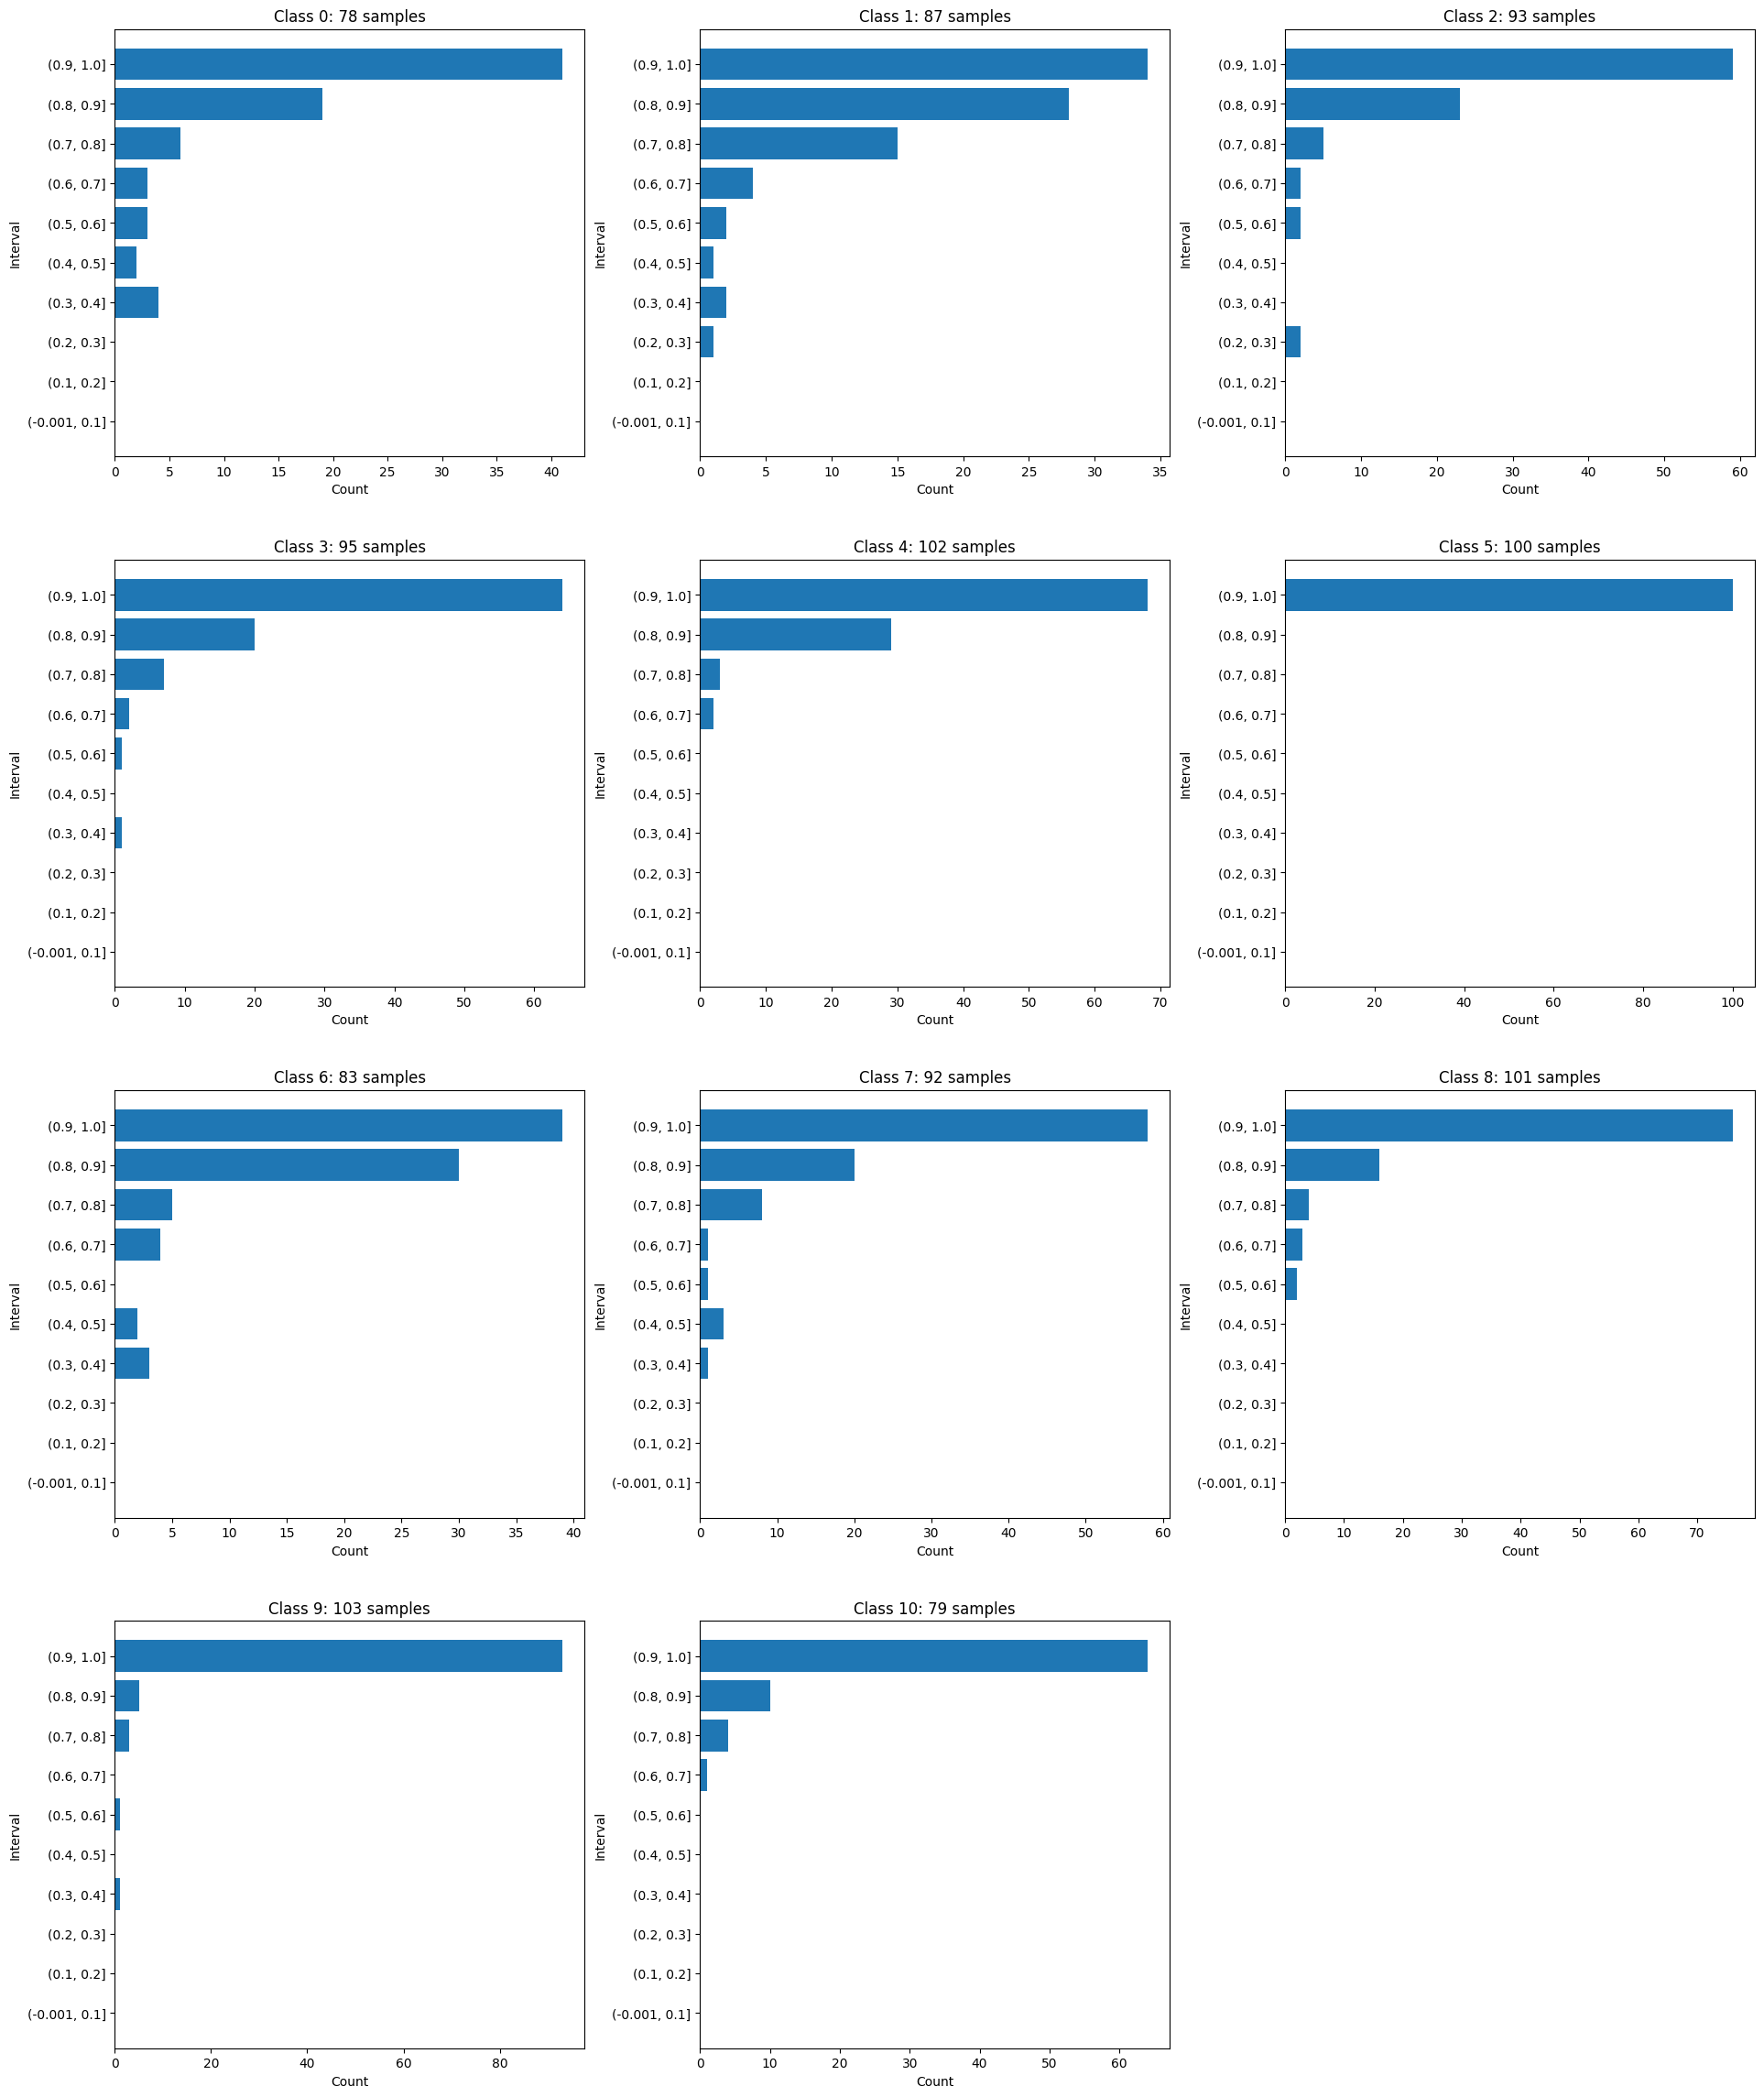

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_subset is your DataFrame

# Define the number of classes
num_classes = 11  # Update this based on the actual number of classes

# Calculate the number of rows needed for the subplots (4 columns)
num_rows = np.ceil(num_classes / 3).astype(int)

# Define the mapping between 'pred_obj_id' and the corresponding confidence score column
mapping = {i: f'class_{i}_conf_score' for i in range(num_classes)}

# Create a figure and axes for the subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(20, num_rows * 6))
fig.tight_layout(pad=6.0)

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Loop over the mapping
for idx, (pred_obj_id, conf_score_column) in enumerate(mapping.items()):
    # Filter the DataFrame by 'pred_obj_id'
    df_cal_tp = df_subset[df_subset['pred_obj_id'] == pred_obj_id]
    
    # Categorize the data into 0.1 intervals
    df_cal_tp[conf_score_column] = pd.cut(df_cal_tp[conf_score_column], bins=np.arange(0, 1.1, 0.1), include_lowest=True)
    
    # Count the number of occurrences in each interval
    counts = df_cal_tp[conf_score_column].value_counts().sort_index()
    
    # Calculate the total count
    total_count = counts.sum()
    
    # Plot on the respective subplot using horizontal bars
    axs[idx].barh([str(interval) for interval in counts.index], counts.values)
    axs[idx].set_ylabel('Interval')
    axs[idx].set_xlabel('Count')
    axs[idx].set_title(f'Class {pred_obj_id}: {total_count} samples')

# Hide any unused subplots
for ax in axs[idx+1:]:
    ax.set_visible(False)

plt.show()

In [47]:
from my_functions import (softmax, 
                          softmax_df, 
                          calculate_logit, 
                          calculate_sigmoid, 
                          calculate_softmax,
                          calculate_hinge_scores,
                          calculate_p_values,
                          calculate_prediction_sets)

In [ ]:
# def calculate_sigmoid(df, conf_score_cols, objectness_score_col, sigmoid_cols):
#     """
#     Calculate sigmoid values by dividing conf_score by objectness_score.
#     """
#     df[sigmoid_cols] = df[conf_score_cols] / df[objectness_score_col].values[:, None]
#     return df

In [61]:
# conf_score_columns = [
#     'ascaris_conf_score',
#     'trichuris_conf_score',
#     'hookworm_conf_score',
#     'schistosoma_conf_score']
# objectness_score_col = 'objectness_score'
# sigmoid_cols = [
#     'ascaris_sigmoid',
#     'trichuris_sigmoid',
#     'hookworm_sigmoid',
#     'schistosoma_sigmoid']

# df_calibration = calculate_sigmoid(
#     df_calibration, 
#     conf_score_columns, 
#     objectness_score_col, 
#     sigmoid_cols
# )
# # softmax_columns = [
# #     'ascaris_softmax', 
# #     'trichuris_softmax', 
# #     'hookworm_softmax', 
# #     'schistosoma_softmax']
# # df_calibration = softmax(
# #     df_calibration)

## Calibration stage

In [53]:
# Assuming df_calibration is your DataFrame and it has been prepared with the necessary columns renamed

# Determine the number of classes dynamically
# This assumes class IDs start from 0 and are sequential
num_classes = 11  # Update this based on the actual number of classes or determine dynamically
class_ids = list(range(num_classes))  # Creates a list [0, 1, 2, ..., num_classes-1]

# Construct the confidence score column names dynamically
conf_score_columns = [f'class_{i}_conf_score' for i in class_ids]

# Use the dynamically constructed column names and class IDs in the function call
alphas_cal = hinge(
    df_calibration[conf_score_columns].values,
    class_ids,
    df_calibration[['pred_obj_id']].values
)

cc_std = ConformalClassifier()
cc_std.fit(alphas_cal)
display(cc_std)

ConformalClassifier(fitted=True, mondrian=False)

In [63]:
# alphas_cal = hinge(
#     df_calibration[[
#         'ascaris_sigmoid',
#         'trichuris_sigmoid',
#         'hookworm_sigmoid',
#         'schistosoma_sigmoid']].values,
#     [0,1,2,3],df_calibration[['pred_obj_id']].values
# )
# cc_std = ConformalClassifier()
# cc_std.fit(alphas_cal)
# display(cc_std)

ConformalClassifier(fitted=True, mondrian=False)

## Testing stage

### Applying the hinge on the testing dataset

In [58]:
# Assuming the number of classes is known or determined dynamically
num_classes = 11  # Update this based on the actual number of classes

# Dynamically construct the confidence score column names
conf_score_columns = [f'class_{i}_conf_score' for i in range(num_classes)]

hinge_score_cols = [f'class_{i}_hinge_score' for i in range(num_classes)]

df_testing = calculate_hinge_scores(
    df_testing, 
    conf_score_columns, 
    hinge_score_cols)



C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [63]:
p_value_cols = [f'class_{i}_p_value' for i in range(num_classes)]
df_testing = calculate_p_values(
    df_testing, 
    hinge_score_cols, 
    p_value_cols, 
    cc_std)

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [65]:
p_set_cols = [f'class_{i}_p_set' for i in range(num_classes)]
df_testing = calculate_prediction_sets(
    df_testing, 
    hinge_score_cols, 
    p_set_cols, 
    cc_std,
    confidence=0.99)

C:\Users\M\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [68]:
non_confirmity_scores = df_testing[df_testing['gt_obj_id']!='-'][hinge_score_cols].values
non_confirmity_scores = non_confirmity_scores.astype(np.float64)
classes = list(range(num_classes))
y_test = df_testing[df_testing['gt_obj_id'].notna()]['gt_obj_id'].values
y_test = y_test.astype(np.int64)
cc_std.evaluate(non_confirmity_scores,classes, y_test, metrics=['error','avg_c','one_c','empty'])

{'error': 0.9233644859813084,
 'avg_c': 0.9626168224299065,
 'one_c': 0.9626168224299065,
 'empty': 0.22242990654205608}

### 1. Singleton TPs

In [69]:
# Filter out '-' class
df_testing_filtered = df_testing[df_testing['gt_obj_id'].notna()]

# Calculate counts
gt_counts = df_testing_filtered['gt_obj_id'].value_counts()
pred_counts = df_testing_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_testing[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id matches pred_obj_id
mask_singleton_tp = (one_counts == 1) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_tp = df_testing[mask_singleton_tp]
singleton_counts = df_singleton_tp['gt_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1
mask_non_singleton = (one_counts > 1) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])
df_non_singleton_tp = df_testing[mask_non_singleton]
non_singleton_counts = df_non_singleton_tp['gt_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_testing['gt_obj_id'] == df_testing['pred_obj_id'])
df_empty_set_tp = df_testing[mask_empty_set]
empty_set_counts = df_empty_set_tp['gt_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_df = singleton_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Singleton Counts'})
non_singleton_counts_df = non_singleton_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Non-Singleton Counts'})
empty_set_counts_df = empty_set_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Empty Set Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {i: f'class_{i}' for i in range(num_classes)}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton Counts,Non-Singleton Counts,Empty Set Counts
0,class_8,105,125,99,1.0,1.0
1,class_0,105,73,65,2.0,NaN
2,class_9,101,105,101,NaN,NaN
3,class_4,101,100,100,NaN,NaN
4,class_5,99,113,99,NaN,NaN
5,class_1,98,100,89,NaN,1.0
6,class_10,97,81,78,1.0,2.0
7,class_3,94,92,89,2.0,1.0
8,class_7,93,106,89,NaN,2.0
9,class_6,89,85,79,NaN,1.0


In [76]:
# df_non_singleton_tp[[
#     'gt_obj_id', 
#     'pred_obj_id', 
#     'ascaris_p_set', 
#     'trichuris_p_set', 
#     'hookworm_p_set', 
#     'schistosoma_p_set', 
#     'ascaris_conf_score', 
#     'trichuris_conf_score', 
#     'hookworm_conf_score', 
#     'schistosoma_conf_score'
# ]]


class_columns = [
    'gt_obj_id', 
    'pred_obj_id'
] + [f'class_{i}_p_set' for i in range(num_classes)] + [f'class_{i}_conf_score' for i in range(num_classes)]

df_non_singleton_tp[class_columns]
# df_non_singleton_tp.iloc[0]
# class_columns
# df_non_singleton_tp

,gt_obj_id,pred_obj_id,class_0_p_set,class_1_p_set,class_2_p_set,class_3_p_set,class_4_p_set,class_5_p_set,class_6_p_set,class_7_p_set,...,class_1_conf_score,class_2_conf_score,class_3_conf_score,class_4_conf_score,class_5_conf_score,class_6_conf_score,class_7_conf_score,class_8_conf_score,class_9_conf_score,class_10_conf_score
81,10.0,10.0,0,0,0,0,0,0,0,1,...,0.000825,0.001617,0.000132,0.001524,0.000247,0.000337,0.451346,0.002382,0.000840,0.798625
135,0.0,0.0,1,0,0,0,0,0,0,0,...,0.005092,0.001249,0.005707,0.002124,0.002893,0.002704,0.002168,0.451507,0.001840,0.006270
165,8.0,8.0,0,1,0,0,0,0,0,0,...,0.402088,0.002647,0.001114,0.000777,0.001233,0.000740,0.000964,0.760908,0.000195,0.001880
279,0.0,0.0,1,0,0,0,0,0,0,0,...,0.005736,0.000978,0.005677,0.002748,0.002377,0.002454,0.002376,0.462251,0.001804,0.006180
1124,3.0,3.0,0,0,0,1,0,1,0,0,...,0.000662,0.002099,0.623068,0.000916,0.524132,0.000943,0.000637,0.014360,0.000501,0.000209
1254,3.0,3.0,0,0,0,1,0,0,0,0,...,0.001676,0.002470,0.825604,0.001039,0.005570,0.000624,0.000923,0.368959,0.000257,0.000730


In [27]:
# df_testing[['gt_obj_id', 'pred_obj_id', 'ascaris_p_set', 
#             'trichuris_p_set', 'hookworm_p_set', 'schistosoma_p_set', 
#             'ascaris_conf_score', 'trichuris_conf_score', 
#             'hookworm_conf_score', 'schistosoma_conf_score']].iloc[146]

gt_obj_id                        0
pred_obj_id                      0
ascaris_p_set                    1
trichuris_p_set                  0
hookworm_p_set                   0
schistosoma_p_set                0
ascaris_conf_score        0.898146
trichuris_conf_score      0.005582
hookworm_conf_score       0.013758
schistosoma_conf_score    0.020934
Name: 156, dtype: object

## FNs

In [77]:
# Filter out '-' class and create a new DataFrame
df_filtered = df_testing[df_testing['gt_obj_id'].notna()]

# Calculate counts
gt_counts = df_filtered['gt_obj_id'].value_counts()
pred_counts = df_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_filtered[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id does not match pred_obj_id
mask_singleton_fn = (one_counts == 1) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_fn = df_filtered[mask_singleton_fn]
singleton_counts_fn = df_singleton_fn['gt_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1 and the corresponding class in the set is 0
mask_non_singleton = (one_counts > 1) & ~mask
df_non_singleton_fn = df_filtered[mask_non_singleton]
non_singleton_counts_fn = df_non_singleton_fn['gt_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])
df_empty_set_fn = df_filtered[mask_empty_set]
empty_set_counts_fn = df_empty_set_fn['gt_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_fn_df = singleton_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Singleton FN Counts'})
non_singleton_counts_fn_df = non_singleton_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Non-Singleton FN Counts'})
empty_set_counts_fn_df = empty_set_counts_fn.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'Empty Set FN Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_fn_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_fn_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_fn_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {i: f'class_{i}' for i in range(num_classes)}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton FN Counts,Non-Singleton FN Counts,Empty Set FN Counts
0,class_8,105,125,2.0,NaN,2.0
1,class_0,105,73,33.0,NaN,4.0
2,class_9,101,105,NaN,NaN,NaN
3,class_4,101,100,1.0,NaN,NaN
4,class_5,99,113,NaN,NaN,NaN
5,class_1,98,100,7.0,NaN,1.0
6,class_10,97,81,14.0,NaN,NaN
7,class_3,94,92,2.0,NaN,NaN
8,class_7,93,106,2.0,NaN,NaN
9,class_6,89,85,6.0,NaN,3.0


In [78]:
class_columns = [
    'gt_obj_id', 
    'pred_obj_id'
] + [f'class_{i}_p_set' for i in range(num_classes)] + [f'class_{i}_conf_score' for i in range(num_classes)]

df_empty_set_fn[class_columns]

,gt_obj_id,pred_obj_id,class_0_p_set,class_1_p_set,class_2_p_set,class_3_p_set,class_4_p_set,class_5_p_set,class_6_p_set,class_7_p_set,...,class_1_conf_score,class_2_conf_score,class_3_conf_score,class_4_conf_score,class_5_conf_score,class_6_conf_score,class_7_conf_score,class_8_conf_score,class_9_conf_score,class_10_conf_score
30,6.0,2.0,0,0,0,0,0,0,0,0,...,0.045589,0.305241,0.005569,0.005318,0.010349,0.075404,0.006599,0.003095,0.003277,0.002600
224,8.0,0.0,0,0,0,0,0,0,0,0,...,0.003317,0.000731,0.005327,0.003926,0.005003,0.002137,0.002586,0.057071,0.003145,0.004066
241,0.0,8.0,0,0,0,0,0,0,0,0,...,0.003771,0.001070,0.004784,0.001749,0.070261,0.006423,0.002359,0.314424,0.001649,0.002228
514,6.0,5.0,0,0,0,0,0,0,0,0,...,0.008280,0.002305,0.002320,0.002629,0.353397,0.315284,0.003468,0.004964,0.010925,0.000726
550,8.0,0.0,0,0,0,0,0,0,0,0,...,0.002120,0.000524,0.004049,0.002738,0.004423,0.001316,0.001779,0.022068,0.002672,0.003414
559,6.0,0.0,0,0,0,0,0,0,0,0,...,0.005164,0.001211,0.002784,0.004709,0.013416,0.039775,0.003463,0.006374,0.011269,0.002111
663,0.0,5.0,0,0,0,0,0,0,0,0,...,0.001987,0.001013,0.003352,0.002413,0.352227,0.008411,0.002521,0.014257,0.014562,0.003212
676,1.0,7.0,0,0,0,0,0,0,0,0,...,0.319444,0.002623,0.000311,0.002146,0.000360,0.000685,0.319881,0.001315,0.001431,0.001453
751,0.0,8.0,0,0,0,0,0,0,0,0,...,0.004198,0.001092,0.004145,0.002021,0.054991,0.019206,0.002681,0.254599,0.002563,0.003203
1062,0.0,8.0,0,0,0,0,0,0,0,0,...,0.004206,0.001639,0.005567,0.003076,0.088353,0.006673,0.003163,0.264087,0.004701,0.006719


## FPs


In [79]:
# Filter out '-' class
df_filtered = df_testing[df_testing['gt_obj_id'].notna()]

# Calculate counts
gt_counts = df_filtered['gt_obj_id'].value_counts()
pred_counts = df_filtered['pred_obj_id'].value_counts()

# Create a mask where each value is True if the corresponding value in p_set_cols is 1
mask = (df_filtered[p_set_cols] == 1)

# Sum the True values along the rows. This gives the number of 1s in each row.
one_counts = mask.sum(axis=1)

# Create a mask where each value is True if the corresponding value in one_counts is 1 (singleton) and gt_obj_id does not match pred_obj_id
mask_singleton_fp = (one_counts == 1) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])

# Use the mask to filter the DataFrame
df_singleton_fp = df_filtered[mask_singleton_fp]
singleton_counts_fp = df_singleton_fp['pred_obj_id'].value_counts()

# For non-singleton sets, we want rows where the sum of 1s is more than 1 and the corresponding class in the set is 0
mask_non_singleton = (one_counts > 1) & ~mask
df_non_singleton_fp = df_filtered[mask_non_singleton]
non_singleton_counts_fp = df_non_singleton_fp['pred_obj_id'].value_counts()

# For empty sets, we want rows where the sum of 1s is 0
mask_empty_set = (one_counts == 0) & (df_filtered['gt_obj_id'] != df_filtered['pred_obj_id'])
df_empty_set_fp = df_filtered[mask_empty_set]
empty_set_counts_fp = df_empty_set_fp['pred_obj_id'].value_counts()

# Convert to DataFrame and merge
gt_counts_df = gt_counts.reset_index().rename(columns={'index': 'Class', 'gt_obj_id': 'GT Counts'})
pred_counts_df = pred_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Pred Counts'})
singleton_counts_fp_df = singleton_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Singleton FP Counts'})
non_singleton_counts_fp_df = non_singleton_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Non-Singleton FP Counts'})
empty_set_counts_fp_df = empty_set_counts_fp.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': 'Empty Set FP Counts'})

counts_df = pd.merge(gt_counts_df, pred_counts_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, singleton_counts_fp_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, non_singleton_counts_fp_df, on='Class', how='outer')
counts_df = pd.merge(counts_df, empty_set_counts_fp_df, on='Class', how='outer')

# Create a mapping dictionary
class_mapping = {i: f'class_{i}' for i in range(num_classes)}

# Replace numeric class labels with string labels
counts_df['Class'] = counts_df['Class'].replace(class_mapping)

counts_df

,Class,GT Counts,Pred Counts,Singleton FP Counts,Non-Singleton FP Counts,Empty Set FP Counts
0,class_8,105,125,20.0,NaN,3.0
1,class_0,105,73,3.0,NaN,3.0
2,class_9,101,105,4.0,NaN,NaN
3,class_4,101,100,NaN,NaN,NaN
4,class_5,99,113,12.0,NaN,2.0
5,class_1,98,100,8.0,NaN,NaN
6,class_10,97,81,NaN,NaN,NaN
7,class_3,94,92,NaN,NaN,NaN
8,class_7,93,106,14.0,NaN,1.0
9,class_6,89,85,5.0,NaN,NaN


In [80]:
class_columns = [
    'gt_obj_id', 
    'pred_obj_id'
] + [f'class_{i}_p_set' for i in range(num_classes)] + [f'class_{i}_conf_score' for i in range(num_classes)]

df_empty_set_fp[class_columns]

,gt_obj_id,pred_obj_id,class_0_p_set,class_1_p_set,class_2_p_set,class_3_p_set,class_4_p_set,class_5_p_set,class_6_p_set,class_7_p_set,...,class_1_conf_score,class_2_conf_score,class_3_conf_score,class_4_conf_score,class_5_conf_score,class_6_conf_score,class_7_conf_score,class_8_conf_score,class_9_conf_score,class_10_conf_score
30,6.0,2.0,0,0,0,0,0,0,0,0,...,0.045589,0.305241,0.005569,0.005318,0.010349,0.075404,0.006599,0.003095,0.003277,0.002600
224,8.0,0.0,0,0,0,0,0,0,0,0,...,0.003317,0.000731,0.005327,0.003926,0.005003,0.002137,0.002586,0.057071,0.003145,0.004066
241,0.0,8.0,0,0,0,0,0,0,0,0,...,0.003771,0.001070,0.004784,0.001749,0.070261,0.006423,0.002359,0.314424,0.001649,0.002228
514,6.0,5.0,0,0,0,0,0,0,0,0,...,0.008280,0.002305,0.002320,0.002629,0.353397,0.315284,0.003468,0.004964,0.010925,0.000726
550,8.0,0.0,0,0,0,0,0,0,0,0,...,0.002120,0.000524,0.004049,0.002738,0.004423,0.001316,0.001779,0.022068,0.002672,0.003414
559,6.0,0.0,0,0,0,0,0,0,0,0,...,0.005164,0.001211,0.002784,0.004709,0.013416,0.039775,0.003463,0.006374,0.011269,0.002111
663,0.0,5.0,0,0,0,0,0,0,0,0,...,0.001987,0.001013,0.003352,0.002413,0.352227,0.008411,0.002521,0.014257,0.014562,0.003212
676,1.0,7.0,0,0,0,0,0,0,0,0,...,0.319444,0.002623,0.000311,0.002146,0.000360,0.000685,0.319881,0.001315,0.001431,0.001453
751,0.0,8.0,0,0,0,0,0,0,0,0,...,0.004198,0.001092,0.004145,0.002021,0.054991,0.019206,0.002681,0.254599,0.002563,0.003203
1062,0.0,8.0,0,0,0,0,0,0,0,0,...,0.004206,0.001639,0.005567,0.003076,0.088353,0.006673,0.003163,0.264087,0.004701,0.006719


In [81]:
# Create a mask where each value is True if gt_obj_id is "-"
mask = df_testing['gt_obj_id'].isna()

# Use the mask to filter the DataFrame
df_filtered = df_testing[mask]

def count_sets(df_filtered, p_set_cols, condition, column_name):
    # Create a mask where each value is True if the corresponding value in p_set_cols is 1
    mask = (df_filtered[p_set_cols] == 1)

    # Sum the True values along the rows. This gives the number of 1s in each row.
    one_counts = mask.sum(axis=1)

    # Create a mask based on the condition
    mask_condition = condition(one_counts) & (df_filtered['gt_obj_id'] == '-')

    # Use the mask to filter the DataFrame
    df_condition = df_filtered[mask_condition]

    # Count the sets per class
    condition_counts = df_condition['pred_obj_id'].value_counts()

    # Convert to DataFrame
    condition_counts_df = condition_counts.reset_index().rename(columns={'index': 'Class', 'pred_obj_id': column_name})

    # Create a mapping dictionary
    class_mapping = {i: f'class_{i}' for i in range(num_classes)}

    # Replace numeric class labels with string labels
    condition_counts_df['Class'] = condition_counts_df['Class'].replace(class_mapping)

    return condition_counts_df

# Count the singletons, non-singletons, and empty sets per class
singleton_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x == 1, 'Singleton FP Counts')
non_singleton_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x > 1, 'Non-Singleton FP Counts')
empty_set_counts_fp_df = count_sets(df_filtered, p_set_cols, lambda x: x == 0, 'Empty Set FP Counts')

# Merge the three dataframes on 'Class'
merged_df = pd.merge(singleton_counts_fp_df, non_singleton_counts_fp_df, on='Class', how='outer')
merged_df = pd.merge(merged_df, empty_set_counts_fp_df, on='Class', how='outer')

# Fill NaN values with 0
merged_df = merged_df.fillna(0)

# Convert counts to integers
merged_df['Singleton FP Counts'] = merged_df['Singleton FP Counts'].astype(int)
merged_df['Non-Singleton FP Counts'] = merged_df['Non-Singleton FP Counts'].astype(int)
merged_df['Empty Set FP Counts'] = merged_df['Empty Set FP Counts'].astype(int)

merged_df

,Singleton FP Counts,Non-Singleton FP Counts,Class,Empty Set FP Counts


In [82]:
singleton_counts_fp_df

,Class,Singleton FP Counts


In [40]:
df_testing.to_csv('hinge_seed_100.csv',index=False)